In [1]:
from __future__ import division, print_function, absolute_import
import logging
import time
import tensorflow as tf
import os
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
from config import pathDict
from conv_net.train import Train
from conv_net.test import Test
from data_transformation.data_prep import get_intersecting_images_pin, DumpBatches
from plot import Plot
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


which_net = 'resnet'
batch_prepare = True
train = True
test = True

INPUT the RUN NAME: Options : ("A new run name" or "Any Previous Run Name"
 WHICH_RUN = sam_new
INPUT: Image-type OPTIONS: (assessor, assessor_code, aerial, overlayed, aerial_cropped, streetside and ensemble 
 IMAGE_TYPE = aerial_cropped


In [2]:
# from clean_directories import clean
# clean(dict(overlayed='summary,batch'),which_vendor='google', which_model='resnet')

## PREPARE/DUMP BATCHES:

In [8]:
start_time = time.time()

max_batches = None

if batch_prepare:
    start_time = time.time()
    
    cmn_land_pins, cmn_house_pins = get_intersecting_images_pin(is_assessor=False, is_aerial=False,
                                                                is_streetside=False, is_overlayed=False,
                                                                is_aerial_cropped=True, equal_proportion=True)
    print(len(cmn_land_pins), len(cmn_house_pins))
    
    tr_batch_size = 128
    ts_batch_size = (len(cmn_land_pins) + len(cmn_house_pins))*5 // 100
    cv_batch_size = (len(cmn_land_pins) + len(cmn_house_pins))*5 // 100

    params = dict(
            image_type='aerial_cropped',
            img_in_shape=[400, 400, 3],
            img_out_shape=[224, 224, 3],
            img_resize_shape=[128, 128, 3],
            img_crop_shape=[128, 128, 3],
            tr_batch_size = tr_batch_size,
            cv_batch_size = cv_batch_size,
            ts_batch_size = ts_batch_size,
            enable_rotation=True,
            shuffle_seed=881,
            get_stats=True,
            max_batches=max_batches)
    
    obj_cb = DumpBatches(params)
    obj_cb.dumpStratifiedBatches_balanced_class(cmn_land_pins, cmn_house_pins, is_cvalid_test=True)

print ('--------------- %s seconds ------------------'%(time.time() - start_time))


8339 8339
16678 16678 16678 16678 1667816
--------------- 226.42947602272034 seconds ------------------


# EVALUATE MODELS:
------------

# TRAIN MODEL: Aerial Cropped
------------

# VARIATION 2: Dropouts after every layer: Learning is pretty slow but improves gradually.
-----------------------

In [ ]:
max_batches = 116
start_time = time.time()
if train:
    tr_obj = Train(dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224,224,3],
                        use_checkpoint=True,
                        save_checkpoint=True,
                        write_tensorboard_summary=False
                        ),
              device_type='gpu',
              which_net='resnet')
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, 
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr)  = tr_obj.run(num_epochs=30, num_batches=max_batches, cv_num_batches=1, get_stats_at=10)# + 1)
    
print('----------%s seconds------------'%(str(time.time() - start_time)))

Dumping/Retreiving Checkpoints to/from %s C:\Users\newline\Documents\ImageClassification\data\checkpoints\sam_new\aerial_cropped\resnet
Learning Rate: Initial:  0.0005
Checkpoint latest at:  C:\Users\newline\Documents\ImageClassification\data\checkpoints\sam_new\aerial_cropped\resnet\resnet_epoch_7_batch_116


Mean Values: train_loss = 0.861143, train_acc = 0.856717, train_precision = 0.86338197178, train_recall = 0.849309040575, cv_loss = 0.550780010782, cv_acc = 0.848532938957, cv_precision = 0.856123632483, cv_recall = 0.839506980803


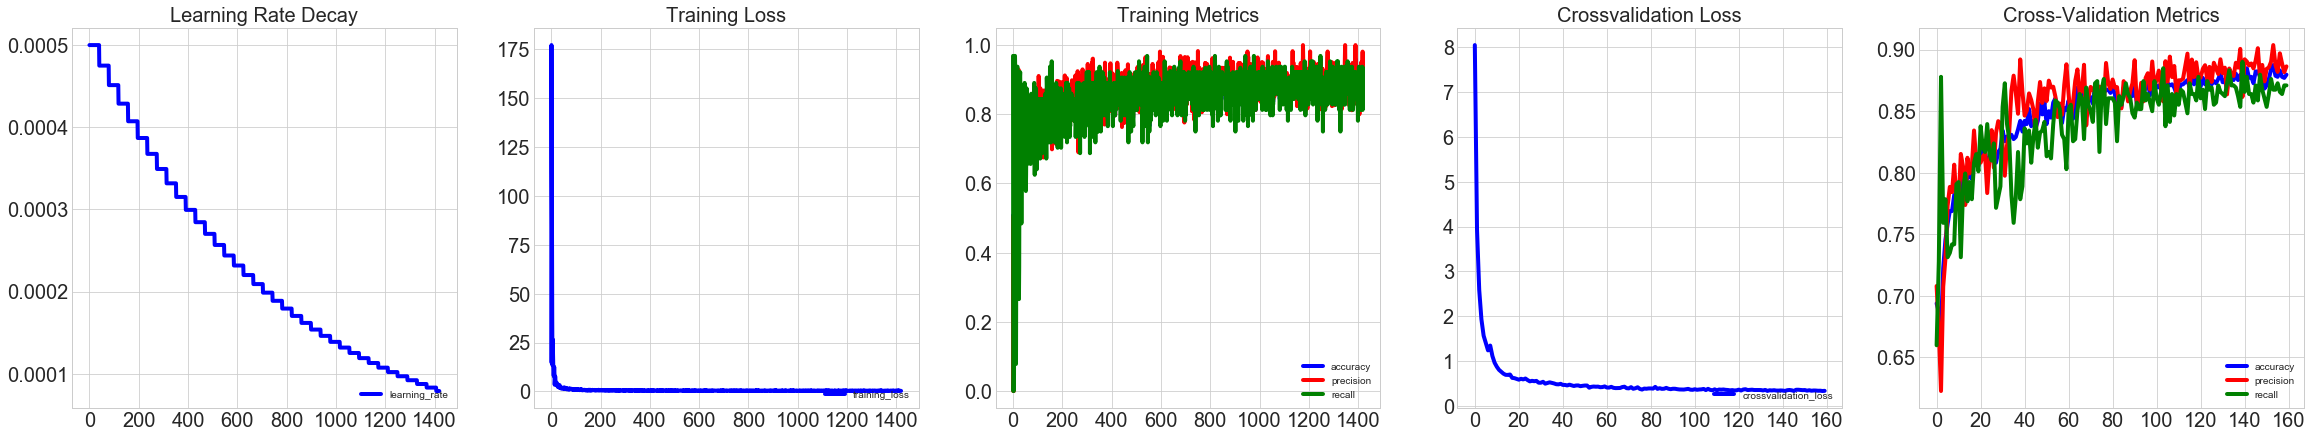

In [3]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))
oj = Plot(rows=1, columns=5, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

In [2]:
which_data = 'cvalid'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224, 224, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='all',
                                which_data=which_data,
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_

In [3]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'cvalid_pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'cvalid_pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
prediction_metrics

,checkpoint,dataset_type,test_loss,test_acc,test_precsion,test_recall
0,epoch_7_batch_89,cvalid,0.250,0.925,0.904,0.952
1,epoch_7_batch_99,cvalid,0.254,0.930,0.911,0.954
2,epoch_7_batch_109,cvalid,0.251,0.931,0.916,0.950
3,epoch_7_batch_116,cvalid,0.244,0.934,0.921,0.950
4,epoch_29_batch_89,cvalid,0.215,0.941,0.924,0.962
5,epoch_29_batch_99,cvalid,0.215,0.944,0.924,0.966
6,epoch_29_batch_109,cvalid,0.215,0.944,0.924,0.966
7,epoch_29_batch_116,cvalid,0.215,0.944,0.924,0.966
8,epoch_30_batch_9,cvalid,0.214,0.944,0.924,0.966


In [4]:
which_data = 'test'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224, 224, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='all',
                                which_data=which_data,
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial

In [5]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'test_pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'test_pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
prediction_metrics

,checkpoint,dataset_type,test_loss,test_acc,test_precsion,test_recall
0,epoch_7_batch_89,test,0.262,0.919,0.903,0.940
1,epoch_7_batch_99,test,0.268,0.913,0.896,0.935
2,epoch_7_batch_109,test,0.267,0.916,0.904,0.930
3,epoch_7_batch_116,test,0.260,0.917,0.906,0.930
4,epoch_29_batch_89,test,0.233,0.929,0.920,0.940
5,epoch_29_batch_99,test,0.233,0.929,0.918,0.942
6,epoch_29_batch_109,test,0.233,0.929,0.918,0.942
7,epoch_29_batch_116,test,0.232,0.928,0.918,0.940
8,epoch_30_batch_9,test,0.231,0.929,0.918,0.942


# VARIATION 3:  Dropout removed from the residual_block_first and maintained accros the resudual_blocks.

In [2]:
max_batches = 70
start_time = time.time()
if train:
    tr_obj = Train(dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224,224,3],
                        learning_rate=0.0005,
                        use_checkpoint=True,
                        save_checkpoint=True,
                        write_tensorboard_summary=False
                        ),
              device_type='gpu',
              which_net='resnet')
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, 
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr)  = tr_obj.run(num_epochs=15, num_batches=max_batches, cv_num_batches=1, get_stats_at=10)# + 1)
    
print('----------%s seconds------------'%(str(time.time() - start_time)))

Dumping/Retreiving Checkpoints to/from %s C:\Users\newline\Documents\ImageClassification\data\checkpoints\sam_new\aerial_cropped\resnet
Learning Rate: Initial:  0.0005
Checkpoints not found, Hence starting at batch 0 and epoch 0........


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


----------3748.544000864029 seconds------------


Mean Values: train_loss = 1.08237, train_acc = 0.845203, train_precision = 0.850863590186, train_recall = 0.8400369115, cv_loss = 0.677143497517, cv_acc = 0.835413030287, cv_precision = 0.83411625389, cv_recall = 0.842248400233


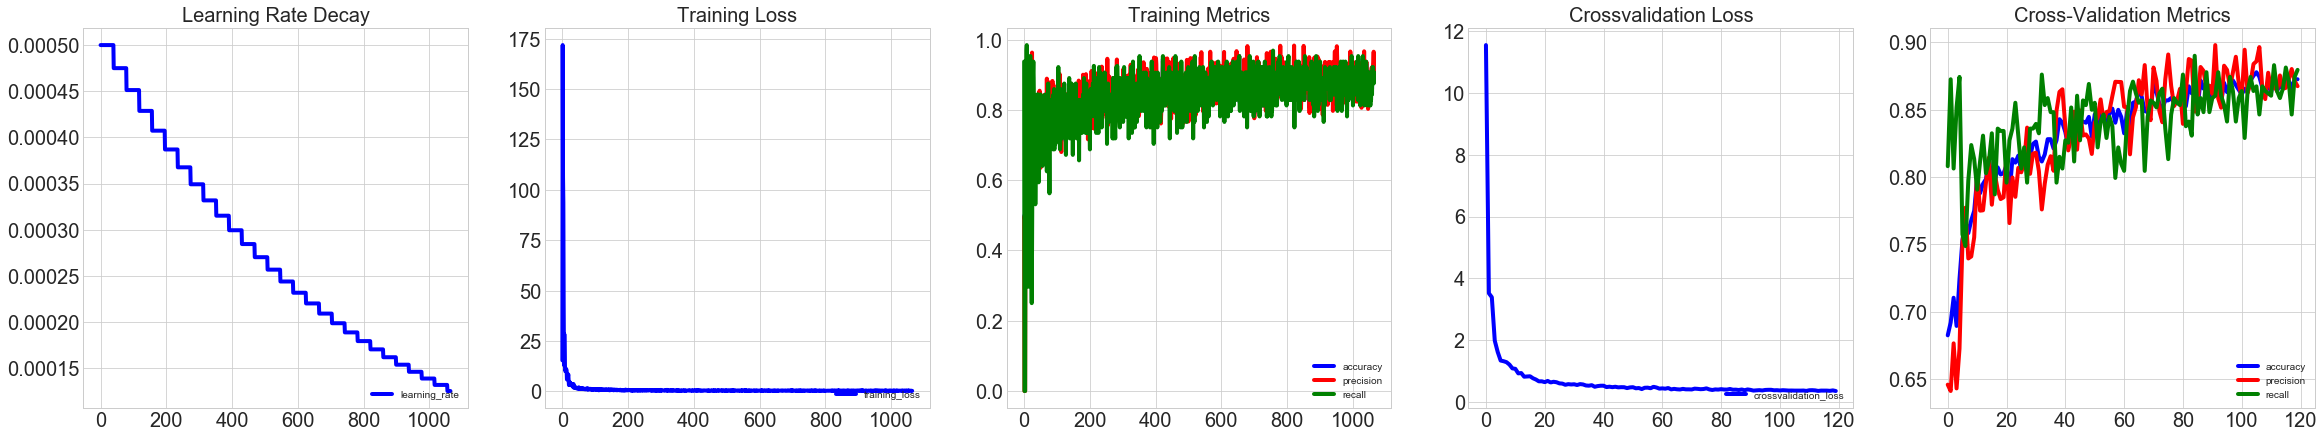

In [4]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))

oj = Plot(rows=1, columns=5, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

In [5]:
which_data = 'cvalid'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224, 224, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='all',
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_

In [6]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
prediction_metrics

,checkpoint,test_batch,test_loss,test_acc,test_precsion,test_recall
0,epoch_13_batch_69,cvalid,0.391,0.884,0.872,0.901
1,epoch_13_batch_70,cvalid,0.394,0.886,0.875,0.901
2,epoch_14_batch_9,cvalid,0.401,0.886,0.880,0.894
3,epoch_14_batch_19,cvalid,0.389,0.888,0.886,0.892
4,epoch_14_batch_29,cvalid,0.391,0.886,0.880,0.894
5,epoch_14_batch_39,cvalid,0.398,0.890,0.881,0.902
6,epoch_14_batch_49,cvalid,0.382,0.890,0.885,0.897
7,epoch_14_batch_59,cvalid,0.364,0.888,0.879,0.901
8,epoch_14_batch_69,cvalid,0.378,0.888,0.878,0.902
9,epoch_14_batch_70,cvalid,0.382,0.888,0.879,0.901


In [7]:
which_data = 'test'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224, 224, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='all',
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial

In [8]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
prediction_metrics

,checkpoint,test_batch,test_loss,test_acc,test_precsion,test_recall
0,epoch_13_batch_69,test,0.309,0.906,0.892,0.923
1,epoch_13_batch_70,test,0.310,0.907,0.894,0.923
2,epoch_14_batch_9,test,0.312,0.908,0.898,0.920
3,epoch_14_batch_19,test,0.306,0.911,0.907,0.916
4,epoch_14_batch_29,test,0.306,0.912,0.904,0.921
5,epoch_14_batch_39,test,0.310,0.909,0.899,0.921
6,epoch_14_batch_49,test,0.305,0.910,0.902,0.920
7,epoch_14_batch_59,test,0.301,0.909,0.897,0.925
8,epoch_14_batch_69,test,0.308,0.909,0.897,0.925
9,epoch_14_batch_70,test,0.310,0.909,0.898,0.923


# VARIATION 4:  Different variation: 
### The input images are 224x224x3 where image is at the center 128x128x3 asn zero padded to make 224x224x3. Here we remove the padding and feed the Resnet with 128x128x3 images

In [2]:
max_batches = 70
start_time = time.time()
if train:
    tr_obj = Train(dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[128,128,3],
                        model_inp_img_shape=[128,128,3],
                        learning_rate=0.0005,
                        use_checkpoint=True,
                        save_checkpoint=True,
                        write_tensorboard_summary=False
                        ),
              device_type='gpu',
              which_net='resnet')
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, 
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr)  = tr_obj.run(num_epochs=15, num_batches=max_batches, cv_num_batches=1, get_stats_at=10)# + 1)
    
print('----------%s seconds------------'%(str(time.time() - start_time)))

Dumping/Retreiving Checkpoints to/from %s C:\Users\newline\Documents\ImageClassification\data\checkpoints\sam_new\aerial_cropped\resnet
Learning Rate: Initial:  0.0005
Checkpoints not found, Hence starting at batch 0 and epoch 0........
----------2122.923999786377 seconds------------


Mean Values: train_loss = 0.784114, train_acc = 0.846013, train_precision = 0.857114713977, train_recall = 0.834537893247, cv_loss = 0.627970277766, cv_acc = 0.834322278202, cv_precision = 0.843314854052, cv_recall = 0.82414194299


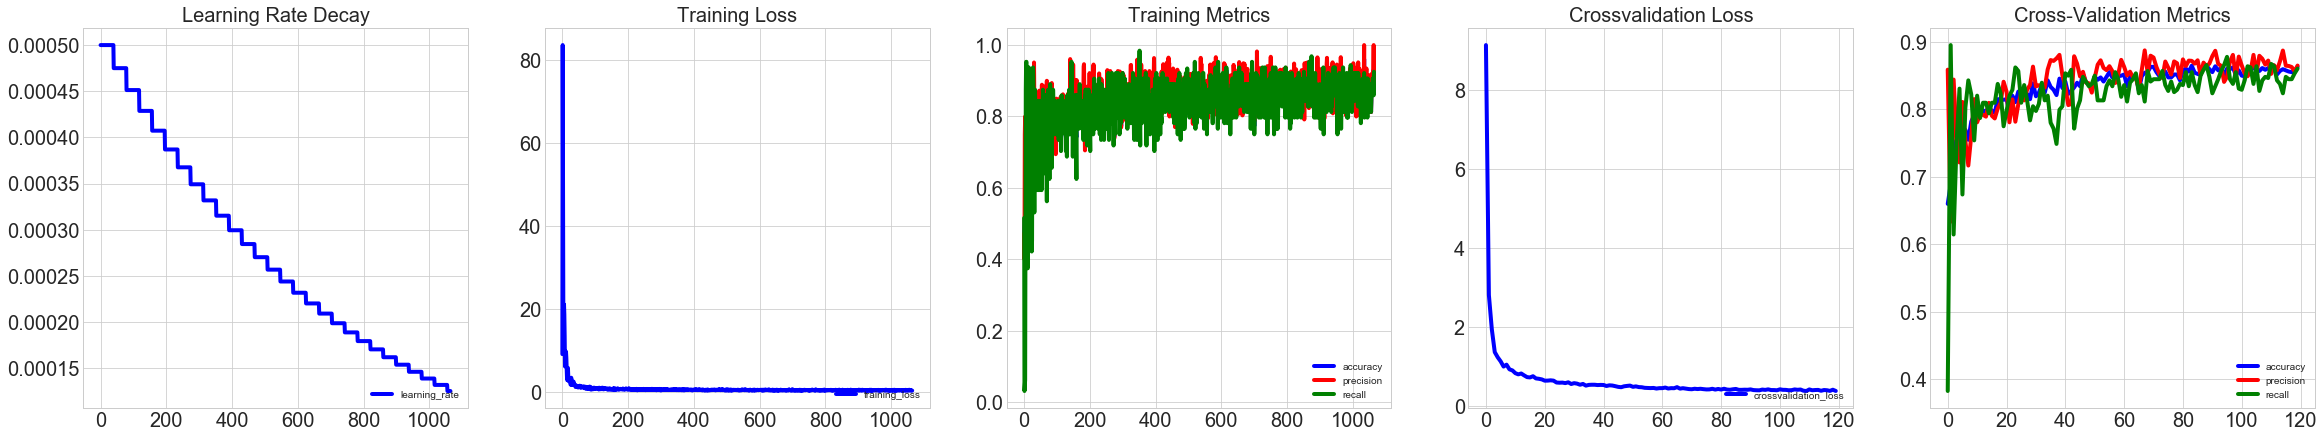

In [3]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))

oj = Plot(rows=1, columns=5, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

In [4]:
which_data = 'cvalid'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[128,128,3],
                        model_inp_img_shape=[128, 128, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='all',
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_

In [6]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
prediction_metrics

,checkpoint,test_batch,test_loss,test_acc,test_precsion,test_recall
0,epoch_13_batch_69,cvalid,0.393,0.872,0.884,0.855
1,epoch_13_batch_70,cvalid,0.397,0.872,0.887,0.852
2,epoch_14_batch_9,cvalid,0.422,0.870,0.885,0.850
3,epoch_14_batch_19,cvalid,0.421,0.867,0.895,0.832
4,epoch_14_batch_29,cvalid,0.412,0.865,0.897,0.824
5,epoch_14_batch_39,cvalid,0.404,0.869,0.891,0.841
6,epoch_14_batch_49,cvalid,0.406,0.870,0.893,0.841
7,epoch_14_batch_59,cvalid,0.394,0.872,0.892,0.846
8,epoch_14_batch_69,cvalid,0.396,0.868,0.882,0.850
9,epoch_14_batch_70,cvalid,0.397,0.870,0.881,0.855


In [7]:
which_data = 'test'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[128,128,3],
                        model_inp_img_shape=[128, 128, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='all',
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial

In [8]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
prediction_metrics

,checkpoint,test_batch,test_loss,test_acc,test_precsion,test_recall
0,epoch_13_batch_69,test,0.337,0.899,0.906,0.890
1,epoch_13_batch_70,test,0.338,0.895,0.904,0.885
2,epoch_14_batch_9,test,0.348,0.897,0.910,0.881
3,epoch_14_batch_19,test,0.353,0.894,0.920,0.864
4,epoch_14_batch_29,test,0.350,0.892,0.918,0.860
5,epoch_14_batch_39,test,0.347,0.899,0.913,0.881
6,epoch_14_batch_49,test,0.348,0.898,0.915,0.878
7,epoch_14_batch_59,test,0.341,0.897,0.910,0.881
8,epoch_14_batch_69,test,0.341,0.900,0.907,0.890
9,epoch_14_batch_70,test,0.341,0.900,0.906,0.892


# Variation 5: Variation 3 looked overall good, lets try with the batch where teh image is rotated by 90 degree it the height is greater than width.

This may not help the model, but should be evaluated as a case

In [2]:
max_batches = 70
start_time = time.time()
if train:
    tr_obj = Train(dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224,224,3],
                        learning_rate=0.0005,
                        use_checkpoint=True,
                        save_checkpoint=True,
                        write_tensorboard_summary=False
                        ),
              device_type='gpu',
              which_net='resnet')
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, 
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr)  = tr_obj.run(num_epochs=20, num_batches=max_batches, cv_num_batches=1, get_stats_at=10)# + 1)
    
print('----------%s seconds------------'%(str(time.time() - start_time)))

Dumping/Retreiving Checkpoints to/from %s C:\Users\newline\Documents\ImageClassification\data\checkpoints\sam_new\aerial_cropped\resnet
Learning Rate: Initial:  0.0005
Checkpoints not found, Hence starting at batch 0 and epoch 0........


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


----------4911.467549085617 seconds------------


Mean Values: train_loss = 0.848651, train_acc = 0.858204, train_precision = 0.866375977295, train_recall = 0.850119084836, cv_loss = 0.537055360153, cv_acc = 0.849061957002, cv_precision = 0.85792766124, cv_recall = 0.838536212914


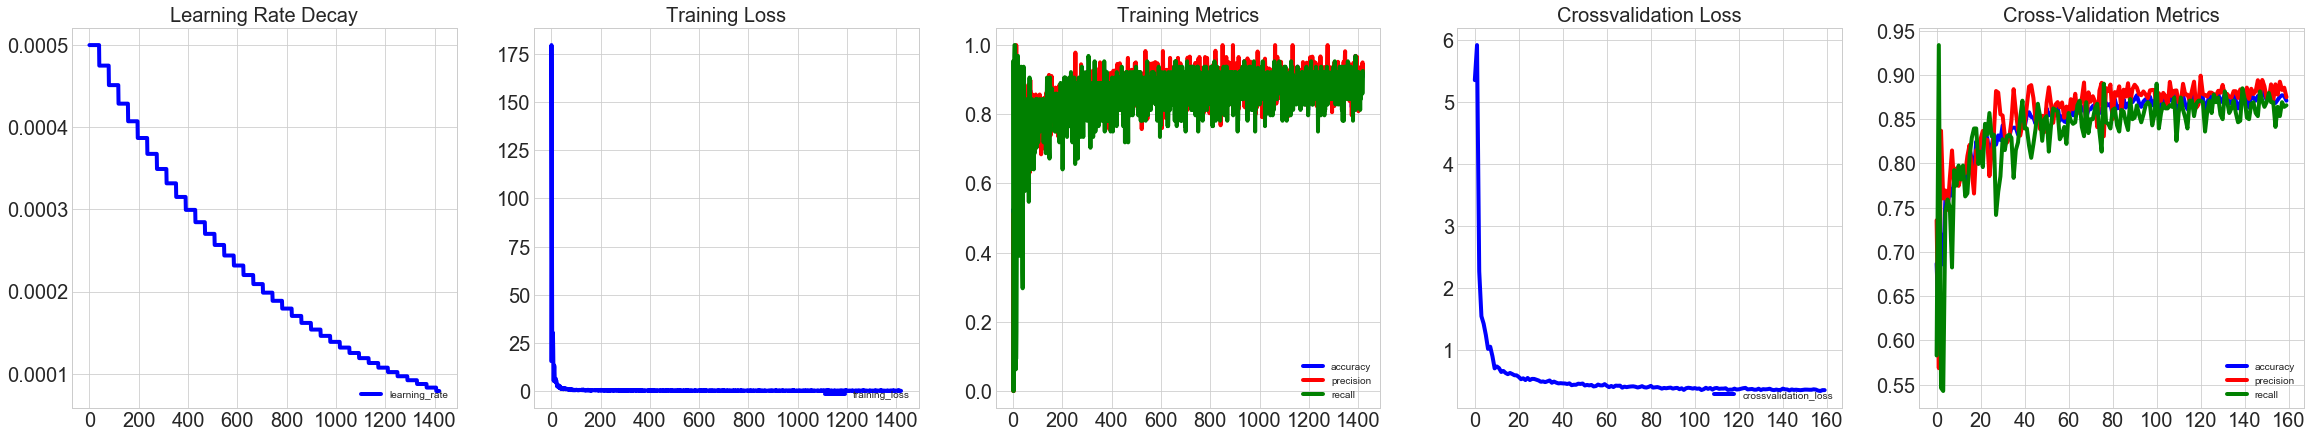

In [3]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))

oj = Plot(rows=1, columns=5, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

In [5]:
which_data = 'cvalid'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224,224,3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='all',
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['cvalid']


In [6]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
prediction_metrics

,checkpoint,test_batch,test_loss,test_acc,test_precsion,test_recall
0,epoch_19_batch_39,cvalid,0.419,0.885,0.878,0.894
1,epoch_19_batch_49,cvalid,0.405,0.891,0.894,0.887
2,epoch_19_batch_59,cvalid,0.391,0.887,0.885,0.888
3,epoch_19_batch_69,cvalid,0.394,0.887,0.884,0.890
4,epoch_19_batch_70,cvalid,0.396,0.887,0.885,0.888


In [7]:
which_data = 'test'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224,224,3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='all',
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\sam_new\aerial_cropped, batch_names: ['test']


In [8]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
prediction_metrics

,checkpoint,test_batch,test_loss,test_acc,test_precsion,test_recall
0,epoch_19_batch_39,test,0.346,0.909,0.902,0.918
1,epoch_19_batch_49,test,0.337,0.914,0.914,0.913
2,epoch_19_batch_59,test,0.330,0.910,0.905,0.916
3,epoch_19_batch_69,test,0.331,0.910,0.905,0.916
4,epoch_19_batch_70,test,0.332,0.910,0.905,0.916


## ROUGH

In [3]:
import numpy as np
import argparse
import imutils
import cv2
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline
dir_in = '/Users/sam/All-Program/App-DataSet/HouseClassification/input_images/sam_new/aerial_cropped/house/20-20-311-043-0000.jpg'

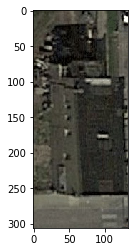

In [6]:
image_in = misc.imread(dir_in)
plt.imshow(image_in)
# plt.show()

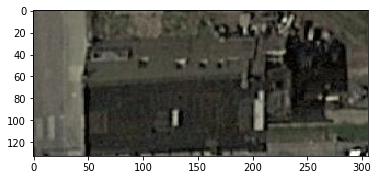

In [13]:
rotated = imutils.rotate_bound(image_in, 90)
plt.imshow(rotated)

In [ ]:
for angle in np.arange(0, 360, 15):
    
    
    cv2.imshow("Rotated (Problematic)", rotated)
	cv2.waitKey(0)

In [15]:
import tensorflow as tf
import numpy as np
X1  = np.random.random((100,512))
X2 = np.random.random((100,512))
X1_tf = tf.constant(X1)
X2_tf = tf.constant(X2)
X3 = tf.concat([X1_tf, X2_tf] , axis=-1)
print (X3.shape)

(100, 1024)
